In [1]:
# Load Modules
from __future__ import print_function
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
import datetime
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
import statsmodels.tsa.api as smtsa

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


- Read data from Drive

In [3]:
# load dataset from drive directory
locust_rainfall_data = pd.read_csv('/content/drive/MyDrive/Hamoye AI labs Projects/Climate Change/ds.csv')
locust_rainfall_data.head()

,Rainfall_Value,X,Y,OBJECTID,STARTDATE,TmSTARTDAT,FINISHDATE,TmFINISHDA,EXACTDATE,PARTMONTH,LOCNAME,AREAHA,LOCRELIAB,COUNTRYID,LOCUSTID,REPORTID,ACOMMENT,LOCPRESENT,SPECIESQRY,CONFIRMATN,BREEDING,REPRELIAB,SHPMINDSQM,SHPMAXDSQM,SHPMINDSIT,SHPMAXDSIT,SHPDENISOL,SHPDENSCAT,SHPDENGRP,SHPDENUNK,SHPSC,SHPSCCAT,SHPMATEGG,SHPMATHAT,SHPMATINS1,SHPMATINS2,SHPMATINS3,SHPMATINS4,SHPMATINS5,SHPMATINS6,...,GADMATMATG,GADMATMAT,GADMATCOP,GADMATLAY,GADMATUNK,GADCOLYL,GADCOLRD,GADMINASKM,GADMAXASKM,GADARVSML,GADARSML,GADARMED,GADARLGE,GADARVLGE,GADARUNK,GADFLYFROM,GADFLYTO,GADHTLOW,GADHTMED,GADHTHI,GADHTUNK,CTLSTDATE,CTLFNDATE,CTLEXACT,CTLPTMONTH,CTLPESTIC,CTLAPPRAT,CTLAPPRATU,CTLQTY,CTLQTYU,CTLARTREA,CTLARTREAU,CTLAPPHAND,CTLAPPVEHI,CTLAPPAIR,CTLAPPMECH,CTLAPPUNK,CTLESTKILL,CAT,Date
0,0.000000,39.066667,13.883333,108,1986/07/15 00:00:00+00,12:00,1986/07/15 00:00:00+00,12:00,Yes,,Malka,0.0,Exact,ET,208534,RAMSES38_1986TOFAOLC,Time period unclear(,1,0,1,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,1899/12/30 00:00:00+00,1899/12/30 00:00:00+00,0,0,,0.0,,0.0,,0.0,,0,0,0,0,0,0,Swarm,1986.07.15
1,0.000000,39.450000,14.333333,113,1986/07/15 00:00:00+00,12:00,1986/07/15 00:00:00+00,12:00,No,Middle,,0.0,Exact,ET,208649,RAMSES38_1986TOFAOLC,(**RefFalse----0-0-F,1,0,1,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,1899/12/30 00:00:00+00,1899/12/30 00:00:00+00,0,0,,0.0,,0.0,,0.0,,0,0,0,0,0,0,Swarm,1986.07.15
2,0.000000,40.233333,14.200000,208,1986/07/15 00:00:00+00,12:00,1986/07/15 00:00:00+00,12:00,No,Middle,Dalol,0.0,Exact,ET,208506,RAMSES38_1986TOFAOLC,(**RefFalse----0-0-F,1,0,1,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,1899/12/30 00:00:00+00,1899/12/30 00:00:00+00,0,0,,0.0,,0.0,,0.0,,0,0,0,0,0,0,Swarm,1986.07.15
3,0.000000,39.000000,12.000000,283,1987/07/19 00:00:00+00,12:00,1987/07/19 00:00:00+00,12:00,No,Middle,Lasta Awraja,904.0,Exact,ET,213210,RAMSES38_1987TOFAOLC,(**RefFalse----1024-,1,0,1,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,9.04,9.04,0,1,0,0,0,0,0,0,0,0,0,0,1987/07/19 00:00:00+00,1987/07/19 00:00:00+00,2,2,indosulphan,0.0,,190.0,l,0.0,,0,0,0,0,0,0,Swarm,1987.07.19
4,6.388474,38.816667,14.450000,296,1987/08/20 00:00:00+00,12:00,1987/08/20 00:00:00+00,12:00,No,Middle,Agama,0.0,Exact,ET,213754,RAMSES38_1987TOFAOLC,(**RefFalse----1599-,1,0,1,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,1987/08/20 00:00:00+00,1987/08/20 00:00:00+00,2,2,Unknown,0.0,,0.0,,3.0,ha,0,0,0,0,0,0,Swarm,1987.08.20


-  Using the `datetime` function convert the Startdate to datetime

In [4]:
# converts the date to datetime
def convert_to_datetime(df):
    df['STARTDATE'] = pd.to_datetime(df['STARTDATE']).apply(lambda x: x.strftime('%Y-%m-%d %H:%M:%S'))
    df['STARTDATE'] = pd.to_datetime(df['STARTDATE'])
    # Get the Year_month of each date
    df['YEAR_MONTH'] = pd.to_datetime(df['STARTDATE']).dt.strftime('%Y-%m')
    return df

In [5]:
# Call the function and assign to the variable `locust_rainfall`
locust_rainfall = convert_to_datetime(locust_rainfall_data)
locust_rainfall.head()

,Rainfall_Value,X,Y,OBJECTID,STARTDATE,TmSTARTDAT,FINISHDATE,TmFINISHDA,EXACTDATE,PARTMONTH,LOCNAME,AREAHA,LOCRELIAB,COUNTRYID,LOCUSTID,REPORTID,ACOMMENT,LOCPRESENT,SPECIESQRY,CONFIRMATN,BREEDING,REPRELIAB,SHPMINDSQM,SHPMAXDSQM,SHPMINDSIT,SHPMAXDSIT,SHPDENISOL,SHPDENSCAT,SHPDENGRP,SHPDENUNK,SHPSC,SHPSCCAT,SHPMATEGG,SHPMATHAT,SHPMATINS1,SHPMATINS2,SHPMATINS3,SHPMATINS4,SHPMATINS5,SHPMATINS6,...,GADMATMAT,GADMATCOP,GADMATLAY,GADMATUNK,GADCOLYL,GADCOLRD,GADMINASKM,GADMAXASKM,GADARVSML,GADARSML,GADARMED,GADARLGE,GADARVLGE,GADARUNK,GADFLYFROM,GADFLYTO,GADHTLOW,GADHTMED,GADHTHI,GADHTUNK,CTLSTDATE,CTLFNDATE,CTLEXACT,CTLPTMONTH,CTLPESTIC,CTLAPPRAT,CTLAPPRATU,CTLQTY,CTLQTYU,CTLARTREA,CTLARTREAU,CTLAPPHAND,CTLAPPVEHI,CTLAPPAIR,CTLAPPMECH,CTLAPPUNK,CTLESTKILL,CAT,Date,YEAR_MONTH
0,0.000000,39.066667,13.883333,108,1986-07-15,12:00,1986/07/15 00:00:00+00,12:00,Yes,,Malka,0.0,Exact,ET,208534,RAMSES38_1986TOFAOLC,Time period unclear(,1,0,1,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,1899/12/30 00:00:00+00,1899/12/30 00:00:00+00,0,0,,0.0,,0.0,,0.0,,0,0,0,0,0,0,Swarm,1986.07.15,1986-07
1,0.000000,39.450000,14.333333,113,1986-07-15,12:00,1986/07/15 00:00:00+00,12:00,No,Middle,,0.0,Exact,ET,208649,RAMSES38_1986TOFAOLC,(**RefFalse----0-0-F,1,0,1,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,1899/12/30 00:00:00+00,1899/12/30 00:00:00+00,0,0,,0.0,,0.0,,0.0,,0,0,0,0,0,0,Swarm,1986.07.15,1986-07
2,0.000000,40.233333,14.200000,208,1986-07-15,12:00,1986/07/15 00:00:00+00,12:00,No,Middle,Dalol,0.0,Exact,ET,208506,RAMSES38_1986TOFAOLC,(**RefFalse----0-0-F,1,0,1,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,1899/12/30 00:00:00+00,1899/12/30 00:00:00+00,0,0,,0.0,,0.0,,0.0,,0,0,0,0,0,0,Swarm,1986.07.15,1986-07
3,0.000000,39.000000,12.000000,283,1987-07-19,12:00,1987/07/19 00:00:00+00,12:00,No,Middle,Lasta Awraja,904.0,Exact,ET,213210,RAMSES38_1987TOFAOLC,(**RefFalse----1024-,1,0,1,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,9.04,9.04,0,1,0,0,0,0,0,0,0,0,0,0,1987/07/19 00:00:00+00,1987/07/19 00:00:00+00,2,2,indosulphan,0.0,,190.0,l,0.0,,0,0,0,0,0,0,Swarm,1987.07.19,1987-07
4,6.388474,38.816667,14.450000,296,1987-08-20,12:00,1987/08/20 00:00:00+00,12:00,No,Middle,Agama,0.0,Exact,ET,213754,RAMSES38_1987TOFAOLC,(**RefFalse----1599-,1,0,1,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,1987/08/20 00:00:00+00,1987/08/20 00:00:00+00,2,2,Unknown,0.0,,0.0,,3.0,ha,0,0,0,0,0,0,Swarm,1987.08.20,1987-08


- Select the Columns we need for our analysis and modeling

In [6]:
# Select the columns we need for our analysis
dataset = locust_rainfall[['STARTDATE', 'YEAR_MONTH', 'COUNTRYID', 'LOCPRESENT', 'Rainfall_Value']]
dataset.head()

,STARTDATE,YEAR_MONTH,COUNTRYID,LOCPRESENT,Rainfall_Value
0,1986-07-15,1986-07,ET,1,0.000000
1,1986-07-15,1986-07,ET,1,0.000000
2,1986-07-15,1986-07,ET,1,0.000000
3,1987-07-19,1987-07,ET,1,0.000000
4,1987-08-20,1987-08,ET,1,6.388474


- Replace missing Rainfall Values with `0`

In [7]:
# function to replace missing rainfall values with `0`
def replace_norainfall(df):
    # Replace rows with no rainfall value with zero
    df['Rainfall_Value'].replace(-9999.000000, 0, inplace=True)
    return df
replace_norainfall(dataset)

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4582: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


,STARTDATE,YEAR_MONTH,COUNTRYID,LOCPRESENT,Rainfall_Value
0,1986-07-15 00:00:00,1986-07,ET,1,0.000000
1,1986-07-15 00:00:00,1986-07,ET,1,0.000000
2,1986-07-15 00:00:00,1986-07,ET,1,0.000000
3,1987-07-19 00:00:00,1987-07,ET,1,0.000000
4,1987-08-20 00:00:00,1987-08,ET,1,6.388474
...,...,...,...,...,...
3344,2021-05-19 21:59:59,2021-05,ET,1,0.000000
3345,2021-05-19 21:59:59,2021-05,ET,1,0.000000
3346,2021-05-19 21:59:59,2021-05,ET,1,0.000000
3347,2021-05-19 21:59:59,2021-05,ET,1,0.000000


- Function to resample the data into Monthly grid, aggregating the `rainfall` and `locust present` values by taking it's `sum`.

In [8]:
# Resample function
def resample_locust(df):
    # Make a copy of the dataframe
    locust_sample = df.copy()
    # Set the date as the index
    locust_sample.set_index('STARTDATE', inplace=True)
    # Resample the data into monthly Grid, taking the sum of rainfall and locust present
    locust_sample = pd.DataFrame(locust_sample.resample('MS').agg({'Rainfall_Value': 'sum', 'LOCPRESENT': 'sum'}))
    # return resampled dataset
    return locust_sample

locust_resample = resample_locust(dataset)
locust_resample.head(10)

,Rainfall_Value,LOCPRESENT
STARTDATE,,
1986-07-01,0.000000,3
1986-08-01,0.000000,0
1986-09-01,0.000000,0
1986-10-01,0.000000,0
1986-11-01,0.000000,0
1986-12-01,0.000000,0
1987-01-01,0.663569,2
1987-02-01,0.000000,0
1987-03-01,0.000000,0


In [9]:
# reset index 
locust_resample.reset_index(inplace=True)
# check for data types
locust_resample.dtypes

STARTDATE         datetime64[ns]
Rainfall_Value           float64
LOCPRESENT                 int64
dtype: object

#### Check for Count of Months with Zero Rainfall Values

In [10]:
# function to output months with zero rainfall values
def months_locust_zero(df):
    # Check the months that have zero to no rainfall values
    zero_locust = df[df['Rainfall_Value'] == 0.0]
    # Get the Month and number of months for the locust recession area
    zero_locust['Month'] = pd.to_datetime(zero_locust['STARTDATE']).dt.strftime('%B')
    zero_locust['Month_Num'] = pd.to_datetime(zero_locust['STARTDATE']).dt.strftime('%m')
    return zero_locust

locust_resample_zero = months_locust_zero(locust_resample)
locust_resample_zero.head(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,STARTDATE,Rainfall_Value,LOCPRESENT,Month,Month_Num
0,1986-07-01,0.0,3,July,07
1,1986-08-01,0.0,0,August,08
2,1986-09-01,0.0,0,September,09
3,1986-10-01,0.0,0,October,10
4,1986-11-01,0.0,0,November,11
5,1986-12-01,0.0,0,December,12
7,1987-02-01,0.0,0,February,02
8,1987-03-01,0.0,0,March,03
9,1987-04-01,0.0,1,April,04
10,1987-05-01,0.0,0,May,05


- Function to take the count of the gridded squares with no rainfall values for each month

In [11]:
# Function to get the count of months(Count of gridded squares) with no rainfall value
def count_months(df):
    # Get the Month and Month_num
    new_resample_zero = df[['Month', 'Month_Num']]
    new_resample_zero.sort_values('Month_Num', inplace=True)
    # Take count of the months with/with-no-rainfall value
    monthly_norain = new_resample_zero[['Month', 'Month_Num']].value_counts()
    df = pd.DataFrame(monthly_norain).reset_index()
    df.columns = ['Month', 'Month_Num' ,'Count']
    df.sort_values('Month_Num', inplace=True)
    return df

months_with_rorain = count_months(locust_resample_zero)
months_with_rorain

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,Month,Month_Num,Count
9,January,01,31
2,February,02,33
6,March,03,32
8,April,04,32
5,May,05,32
10,June,06,30
7,July,07,32
11,August,08,30
0,September,09,33
4,October,10,32


- Plot the counts of the months with no rainfall values

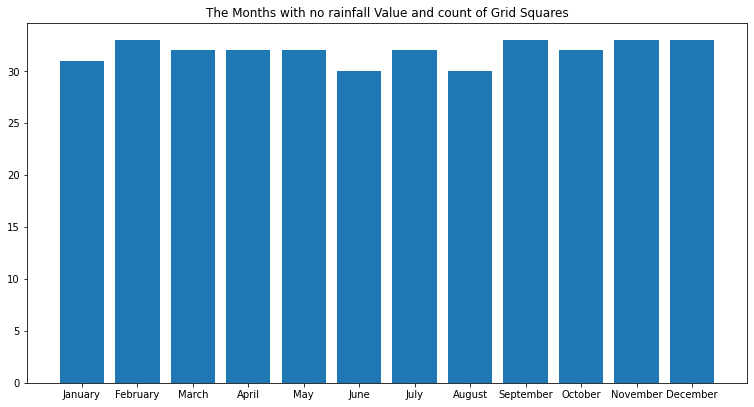

In [12]:
# Plot the counts of the months with no rainfall value
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,5))
ax = fig.add_axes([0,0,1,1])
ax.bar(months_with_rorain['Month'], months_with_rorain['Count'])
plt.title("The Months with no rainfall Value and count of Grid Squares")
plt.show()

#### Check for Count of Months with Rainfall Values

In [13]:
# Function to get months with rainfall value
def months_locust(df):
    # Get data for where we have rainfall values greater than 0
    # Assign this dataframe to a new variable 
    resample_rainfall = df.loc[(df['Rainfall_Value'] > 0.0000)]
    # Get the Month and number of months for the locust recession area
    resample_rainfall['Month'] = pd.to_datetime(resample_rainfall['STARTDATE']).dt.strftime('%B')
    resample_rainfall['Month_Num'] = pd.to_datetime(resample_rainfall['STARTDATE']).dt.strftime('%m')
    return resample_rainfall

locust_resample_rainfall = months_locust(locust_resample)
locust_resample_rainfall.head(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,STARTDATE,Rainfall_Value,LOCPRESENT,Month,Month_Num
6,1987-01-01,0.663569,2,January,01
11,1987-06-01,15.713973,15,June,06
12,1987-07-01,141.305729,52,July,07
13,1987-08-01,60.957065,13,August,08
30,1989-01-01,5.400155,8,January,01
275,2009-06-01,5.460732,7,June,06
276,2009-07-01,9.267832,9,July,07
277,2009-08-01,1.956121,3,August,08
332,2014-03-01,3.399187,6,March,03
333,2014-04-01,30.640301,8,April,04


In [14]:
months_with_rain = count_months(locust_resample_rainfall)
months_with_rain

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,Month,Month_Num,Count
2,January,01,4
10,February,02,2
5,March,03,3
7,April,04,3
4,May,05,3
1,June,06,4
6,July,07,3
0,August,08,5
8,September,09,2
3,October,10,3


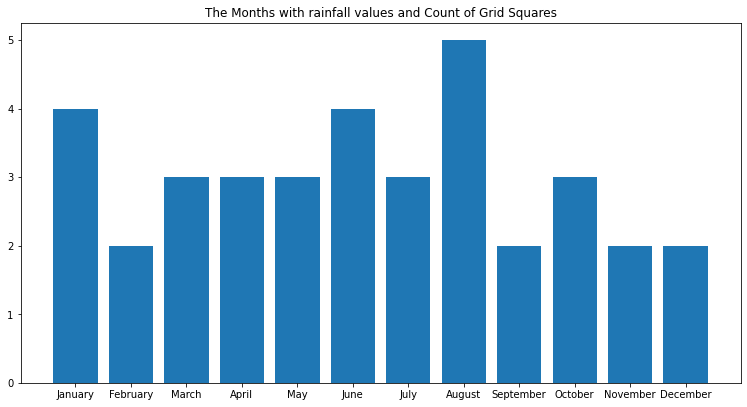

In [15]:
# Plot the counts of the months with rainfall value
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,5))
ax = fig.add_axes([0,0,1,1])
ax.bar(months_with_rain['Month'], months_with_rain['Count'])
plt.title('The Months with rainfall values and Count of Grid Squares')
plt.show()

 #### Interactive plotting with Plotly

In [16]:
# Plotly for time series data
import plotly
import plotly.express as px
import plotly.graph_objects as go
fig = px.line(locust_resample_rainfall, x='STARTDATE', y='Rainfall_Value', title="Time Period By Rainfall Value and Count of Locust Infestation", 
              labels={'Rainfall_Value': "Rainfall Value(mm)",
                      "LOCPRESENT": "LocPresent Value"})
fig.add_scatter(x=locust_resample_rainfall['STARTDATE'], y=locust_resample_rainfall['LOCPRESENT'], mode='lines', showlegend=True, name="LocPresent")


fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
# Show plot 
fig.show()

In [17]:
# Make a copy of the data for plotting
locust_plotly = locust_resample_rainfall.copy()
locust_plotly.head(5)

,STARTDATE,Rainfall_Value,LOCPRESENT,Month,Month_Num
6,1987-01-01,0.663569,2,January,01
11,1987-06-01,15.713973,15,June,06
12,1987-07-01,141.305729,52,July,07
13,1987-08-01,60.957065,13,August,08
30,1989-01-01,5.400155,8,January,01


- Plotly to show the `Date` By the `LOCPRESENT` and `Rainfall Value` in an interactive form. 

In [18]:
# Plotly for time series data
import plotly
import plotly.express as px
fig = px.line(locust_resample, x='STARTDATE', y='Rainfall_Value', title="Time Period By Rainfall Value(either zero or with rainfall value) and Count of Locust Infestation")
fig.add_scatter(x=locust_resample['STARTDATE'], y=locust_resample['LOCPRESENT'], mode='lines', showlegend=True, name="LocPresent")

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
# Show plot 
fig.show()

In [19]:
# Plotly for time series data
import plotly
import plotly.express as px
fig = px.line(locust_plotly, x='STARTDATE', y='Rainfall_Value', title="Time Period By Rainfall Value and Count of Locust Infestation")
fig.add_scatter(x=locust_plotly['STARTDATE'], y=locust_plotly['LOCPRESENT'], mode='lines', showlegend=True)

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
# Show plot 
fig.show()

In [20]:
import plotly
import plotly.express as px
fig = px.line(locust_plotly, x='STARTDATE', y='LOCPRESENT',title='Time Period and Count of Locust Infestation')

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig.show()

In [21]:
import plotly
import plotly.express as px
fig = px.line(locust_plotly, x='STARTDATE', y='Rainfall_Value', title='Time Period By Rainfall Values')

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig.show()

- Summarising the `gridded data` by month showed some evidence of `Seasonality`.

### Import Libraries for preprocessing and Modeling

In [22]:
import pandas as pd 
import itertools
import statsmodels as sm
from statsmodels.tsa import stattools
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa import api as smt
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot

# We will use deprecated models of statmodels which throw a lot of warnings to use more modern ones
import warnings
warnings.filterwarnings("ignore")

- Select the main columns we are working with...

In [23]:
locust_resample_rainfall = locust_resample_rainfall[['STARTDATE', 'Rainfall_Value', 'LOCPRESENT']]
len(locust_resample_rainfall)

36

In [24]:
# Saving the dataframe with rainfall
locust_resample_rainfall.to_csv(r"/content/drive/MyDrive/Hamoye AI labs Projects/Climate Change/Model/locust_resample_rainfall.csv", index=False)

#### Check for Seasonality using the `Augmented Dickey-Fuller Test`.

#### Augmented Dickey-Fuller test

- Statistical tests make strong assumptions about your data. They can only be used to inform the degree to which a null hypothesis can be rejected or fail to be reject. The result must be interpreted for a given problem to be meaningful.

- Nevertheless, they can provide a quick check and confirmatory evidence that your time series is stationary or non-stationary.

- The Augmented Dickey-Fuller test is a type of statistical test called a unit root test.

- The intuition behind a unit root test is that it determines how strongly a time series is defined by a trend.

- There are a number of unit root tests and the Augmented Dickey-Fuller may be one of the more widely used. It uses an autoregressive model and optimizes an information criterion across multiple different lag values.

- The null hypothesis of the test is that the time series can be represented by a unit root, that it is not stationary (has some time-dependent structure). The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.

- `Null Hypothesis (H0)`: If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.
- `Alternate Hypothesis (H1)`: The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.


We interpret this result using the p-value from the test. A p-value below a threshold (such as 5% or 1%) suggests we reject the null hypothesis (stationary), otherwise a p-value above the threshold suggests we fail to reject the null hypothesis (non-stationary).

- `p-value > 0.05`: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
- `p-value <= 0.05`: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

#### Mean and Variance Check

- The `stationarity` and `non-stationarity` can also be checked by evaluating `mean` and `variance` in different time periods.

- Split the data into two halves and examine the `mean` and the `variance`.

In [25]:
def check_mean(dataf):
    mean1, mean2 = dataf.iloc[:18].LOCPRESENT.mean(), dataf.iloc[18:].LOCPRESENT.mean()
    return 'mean1=%f, mean2=%f' % (mean1, mean2)

In [26]:
def check_variance(dataf):
    var1, var2 = dataf.iloc[:18].LOCPRESENT.var(), dataf.iloc[18:].LOCPRESENT.var()
    return 'variance1=%f, variance2=%f' % (var1, var2)

In [27]:
check_mean(locust_resample_rainfall), check_variance(locust_resample_rainfall)

('mean1=16.833333, mean2=168.166667',
 'variance1=330.264706, variance2=18386.617647')

- `ADF`

In [28]:
def adf(dataf, column_name=None):
    adf_result = stattools.adfuller(dataf[column_name].dropna(), autolag='AIC')
    print('ADF Statistics {}'.format(adf_result[0]))
    print('p-val of the ADF test in Locust data :', adf_result[1])
    print("Num Of Lags : ", adf_result[2])
    print("Num Of Observations Used For ADF Regression and Critical Values Calculation :", adf_result[3])
    for key, value in adf_result[4].items():
        print('\t{}: {}'.format(key, value))
    
    if adf_result[1] <= 0.05:
        print("Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [29]:
adf(locust_resample_rainfall, column_name='LOCPRESENT')

ADF Statistics 1.2541966439838077
p-val of the ADF test in Locust data : 0.9963397515243247
Num Of Lags :  7
Num Of Observations Used For ADF Regression and Critical Values Calculation : 28
	1%: -3.6889256286443146
	5%: -2.9719894897959187
	10%: -2.6252957653061224
Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


#### Check for `Autocorrelation Function` and `Partial Autocorrelation Function` of the Untransformed Locust data.

In [30]:
def auto_plot(dataf, lags, column_name = None):
    # iterates over the values of the lags starting from 0 to last lag value.
    lag = range(0,lags)
    locust_acf = []
    for l in lag:
        locust_acf.append(dataf[column_name].autocorr(l))

    plt.figure(figsize=(11.5, 6.5))
    plt.plot(locust_acf, marker='*', color='g')
    plt.title('Autocorrelation function')
    plt.xlabel('Lag in terms of number of months')
    plt.ylabel('Correlation')

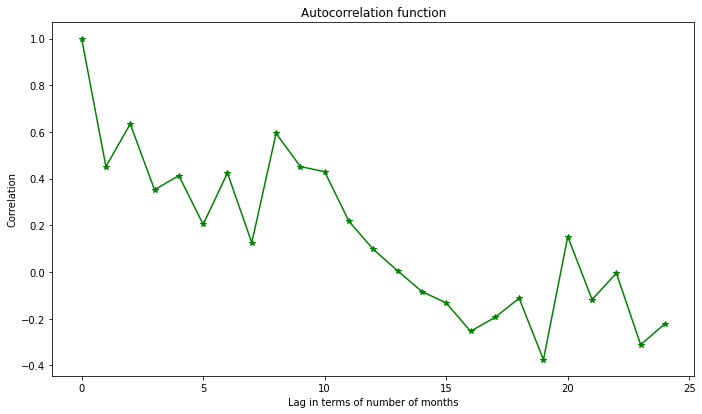

In [31]:
auto_plot(locust_resample_rainfall, 25, column_name='LOCPRESENT')

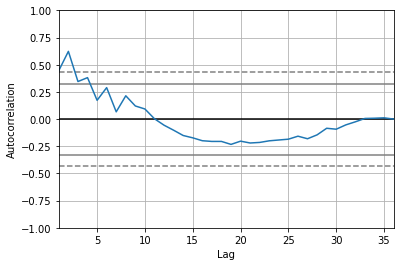

In [32]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(locust_resample_rainfall['LOCPRESENT'])

#### `AutoCorrelation Function` and `Partial AutoCorrelation Function` plot of the `Untransformed LOCUST DATA`.

In [ ]:
def acf_pacf_plot(dataf, column_name=None):
    fig = plt.figure(figsize = (15,15))
    ax1 = fig.add_subplot(211)
    fig = sm.graphics.tsa.plot_acf(dataf[column_name],lags = 25,ax = ax1) #.iloc[13:]
    ax2 = fig.add_subplot(212)
    fig = sm.graphics.tsa.plot_pacf(dataf[column_name],lags = 25, ax = ax2) #.iloc[13:]

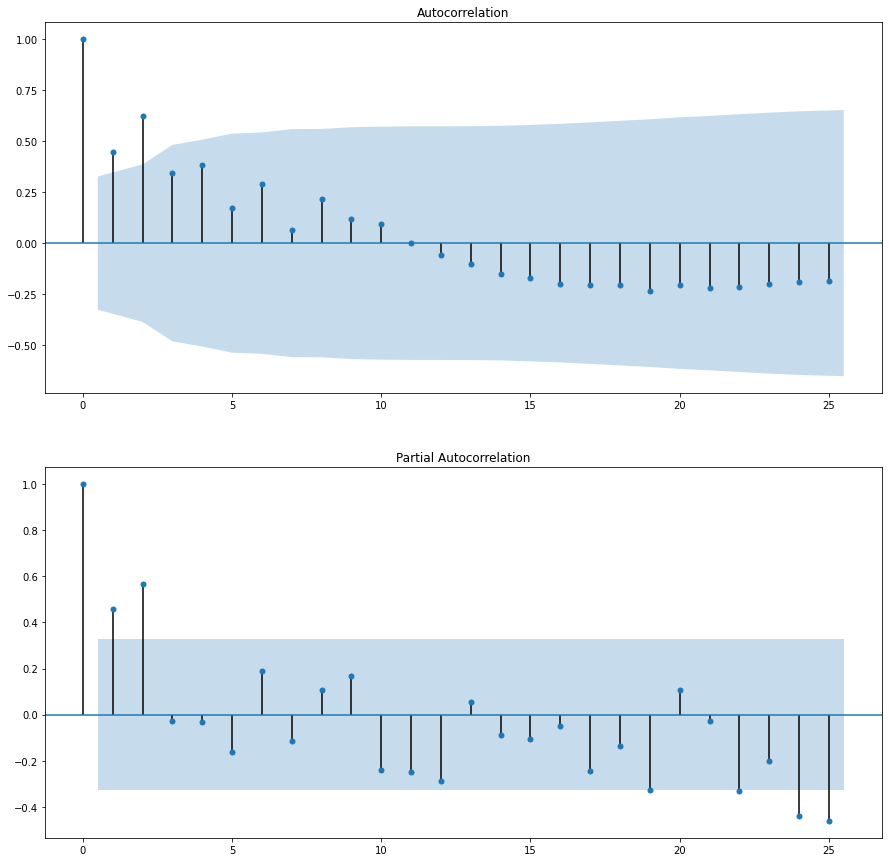

In [ ]:
acf_pacf_plot(locust_resample_rainfall, column_name= 'LOCPRESENT')

#### Square-root transformation of the locust data

In [ ]:
def square_transform(dataf):
    dataf['Square_root_transformed_locust'] = np.sqrt(dataf['LOCPRESENT'])
    return dataf

In [ ]:
locust_resample_rainfall = square_transform(locust_resample_rainfall)
locust_resample_rainfall.head(7)

,STARTDATE,Rainfall_Value,LOCPRESENT,Square_root_transformed_locust
6,1987-01-01,0.663569,2,1.414214
11,1987-06-01,15.713973,15,3.872983
12,1987-07-01,141.305729,52,7.211103
13,1987-08-01,60.957065,13,3.605551
30,1989-01-01,5.400155,8,2.828427
275,2009-06-01,5.460732,7,2.645751
276,2009-07-01,9.267832,9,3.000000


In [ ]:
# save the `Squared-transformed-locust` data as a csv file
locust_resample_rainfall.to_csv(r"/content/drive/MyDrive/Hamoye AI labs Projects/Climate Change/Model/locust_square_transform.csv", index=False)

- Evaluate the `mean` and `Variance` of the `Square-root transformed locust data`. 

In [ ]:
def check_mean(dataf):
    mean1, mean2 = dataf.iloc[:18].Square_root_transformed_locust.mean(), dataf.iloc[18:].Square_root_transformed_locust.mean()
    return 'mean1=%f, mean2=%f' % (mean1, mean2)

def check_variance(dataf):
    var1, var2 = dataf.iloc[:18].Square_root_transformed_locust.var(), dataf.iloc[18:].Square_root_transformed_locust.var()
    return 'variance1=%f, variance2=%f' % (var1, var2)

In [ ]:
check_mean(locust_resample_rainfall), check_variance(locust_resample_rainfall)

('mean1=3.624177, mean2=12.105077', 'variance1=3.916247, variance2=22.906349')

- `ADF` of the `Square-root transformed locust data`.

In [ ]:
adf(locust_resample_rainfall, column_name = 'Square_root_transformed_locust')

ADF Statistics -1.4935243032614032
p-val of the ADF test in Locust data : 0.536712306588102
Num Of Lags :  1
Num Of Observations Used For ADF Regression and Critical Values Calculation : 34
	1%: -3.639224104416853
	5%: -2.9512301791166293
	10%: -2.614446989619377
Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


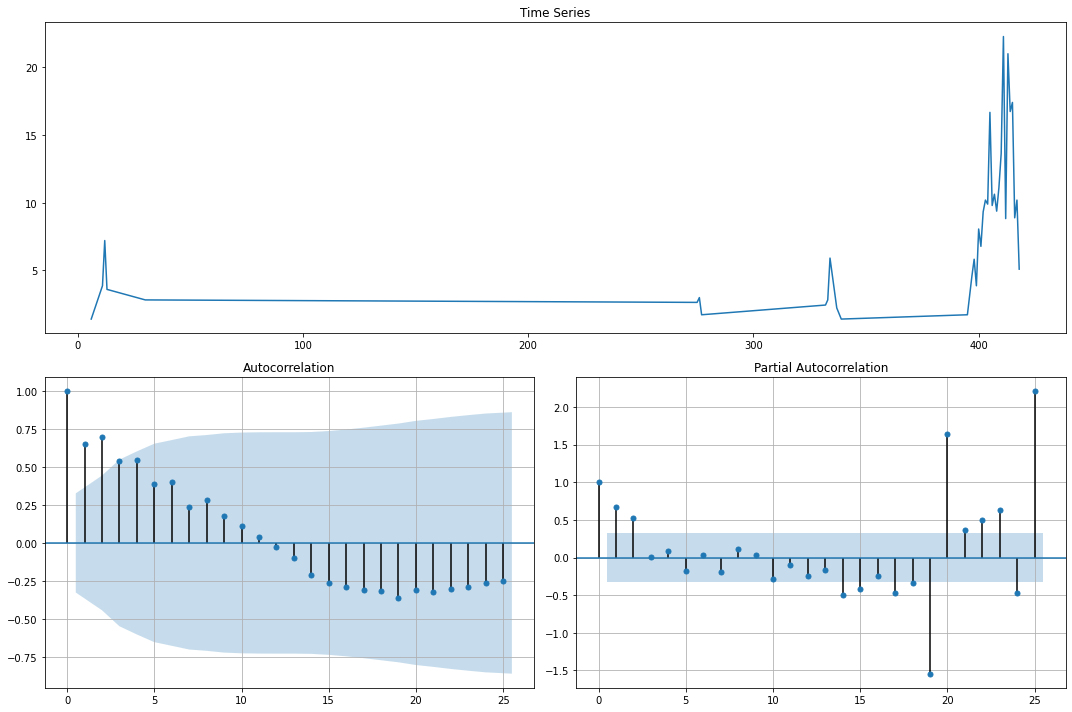

In [ ]:
# Function to plot signal, ACF and PACF
def plotds(xt, nlag=25, fig_size=(15, 10)):
    if not isinstance(xt, pd.Series):
         xt = pd.Series(xt)
    plt.figure(figsize=fig_size)
    layout = (2, 2)
    
    
    # Assign axes
    ax_xt = plt.subplot2grid(layout, (0, 0), colspan=2)
    plt.grid(True)
    ax_acf= plt.subplot2grid(layout, (1, 0))
    plt.grid(True)
    ax_pacf = plt.subplot2grid(layout, (1, 1))
    plt.grid(True)
    
    # Plot graphs
    xt.plot(ax=ax_xt)
    ax_xt.set_title('Time Series')
    plot_acf(xt, lags=25, ax=ax_acf)
    plot_pacf(xt, lags=25, ax=ax_pacf)
    plt.tight_layout()
    return None


# Plot ACF and PACF
plotds(locust_resample_rainfall['Square_root_transformed_locust'], nlag=25)

- The `Autocorrelation function` plot has too many significant lags.

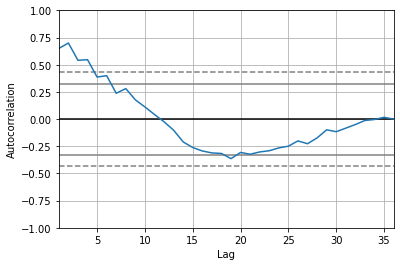

In [ ]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(locust_resample_rainfall['Square_root_transformed_locust'])

#### First Order Differencing of the `Square root transformed locust data`.

In [ ]:
# Taking the first Difference of the Square root transformed locust data
locust_difference = locust_resample_rainfall.copy()
locust_difference['Locust_First_Difference'] = locust_difference['Square_root_transformed_locust'].diff()
locust_difference.head()

,STARTDATE,Rainfall_Value,LOCPRESENT,Square_root_transformed_locust,Locust_First_Difference
6,1987-01-01,0.663569,2,1.414214,NaN
11,1987-06-01,15.713973,15,3.872983,2.458770
12,1987-07-01,141.305729,52,7.211103,3.338119
13,1987-08-01,60.957065,13,3.605551,-3.605551
30,1989-01-01,5.400155,8,2.828427,-0.777124


In [ ]:
# Save the differenced locust dataset
locust_difference.to_csv(r"/content/drive/MyDrive/Hamoye AI labs Projects/Climate Change/Model/locust_difference.csv", index=False)

In [ ]:
adf(locust_difference, column_name = 'Locust_First_Difference')

ADF Statistics -10.915040775895338
p-val of the ADF test in Locust data : 1.0728372960599408e-19
Num Of Lags :  0
Num Of Observations Used For ADF Regression and Critical Values Calculation : 34
	1%: -3.639224104416853
	5%: -2.9512301791166293
	10%: -2.614446989619377
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


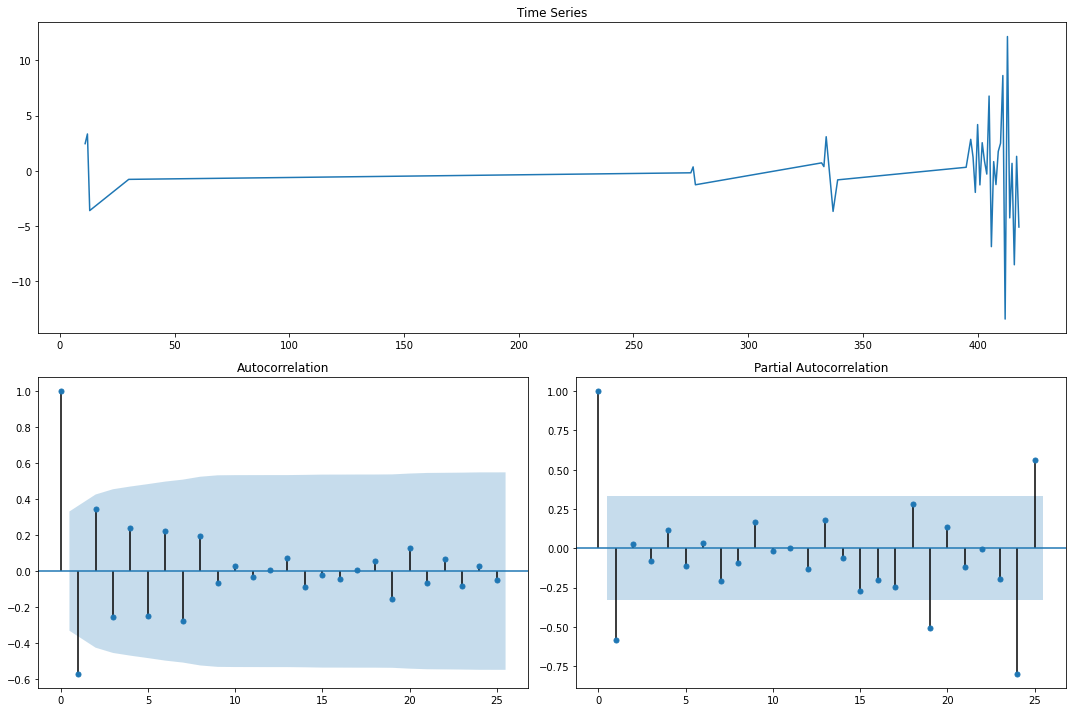

In [ ]:
# Plot ACF and PACF
plotds(locust_difference['Locust_First_Difference'].dropna(), nlag=25)

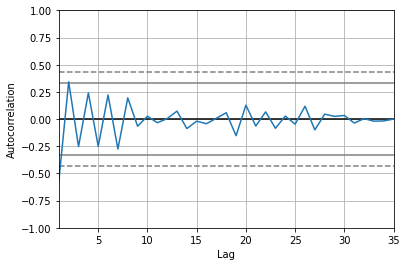

In [ ]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(locust_difference['Locust_First_Difference'].dropna())

#### Seasonal First Difference of the Locust data

In [ ]:
locust_difference['Seasonal_first_difference'] = locust_difference['Square_root_transformed_locust'].diff(4).diff()  # 3 was okay
locust_difference.head(15)

,STARTDATE,Rainfall_Value,LOCPRESENT,Square_root_transformed_locust,Locust_First_Difference,Seasonal_first_difference
6,1987-01-01,0.663569,2,1.414214,NaN,NaN
11,1987-06-01,15.713973,15,3.872983,2.458770,NaN
12,1987-07-01,141.305729,52,7.211103,3.338119,NaN
13,1987-08-01,60.957065,13,3.605551,-3.605551,NaN
30,1989-01-01,5.400155,8,2.828427,-0.777124,-3.235894
275,2009-06-01,5.460732,7,2.645751,-0.182676,-3.520795
276,2009-07-01,9.267832,9,3.000000,0.354249,3.959800
277,2009-08-01,1.956121,3,1.732051,-1.267949,-0.490825
332,2014-03-01,3.399187,6,2.449490,0.717439,0.900115
333,2014-04-01,30.640301,8,2.828427,0.378937,0.024689


In [ ]:
def check_mean(dataf):
    mean1, mean2 = dataf.iloc[:18].Seasonal_first_difference.mean(), dataf.iloc[18:].Seasonal_first_difference.mean()
    return 'mean1=%f, mean2=%f' % (mean1, mean2)

def check_variance(dataf):
    var1, var2 = dataf.iloc[:18].Seasonal_first_difference.var(), dataf.iloc[18:].Seasonal_first_difference.var()
    return 'variance1=%f, variance2=%f' % (var1, var2)

In [ ]:
check_mean(locust_difference), check_variance(locust_difference)

('mean1=0.092025, mean2=-0.877087', 'variance1=10.831393, variance2=89.734706')

In [ ]:
adf(locust_difference, column_name = 'Seasonal_first_difference')

ADF Statistics -3.244695748194893
p-val of the ADF test in Locust data : 0.01753896889946308
Num Of Lags :  6
Num Of Observations Used For ADF Regression and Critical Values Calculation : 25
	1%: -3.7238633119999998
	5%: -2.98648896
	10%: -2.6328004
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


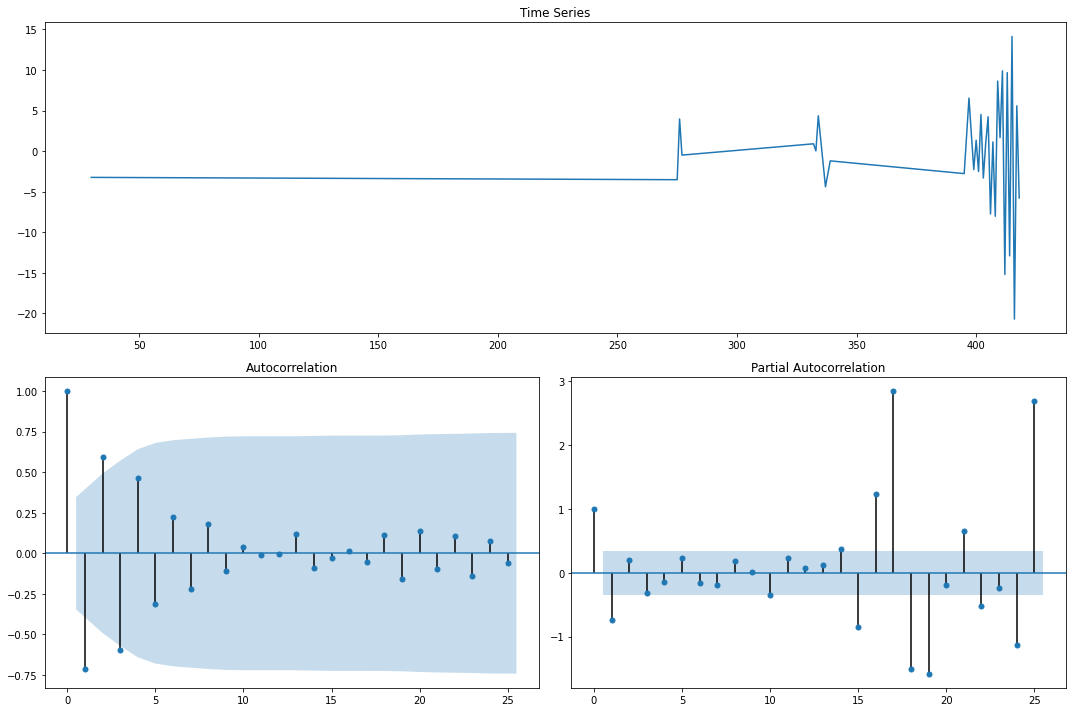

In [ ]:
# Plot ACF and PACF
plotds(locust_difference['Seasonal_first_difference'].dropna(), nlag=25)

- Things to check out using the dataset

- `ADF`

- The ADF tests gives the following results – test statistic, p value and the critical value at 1%, 5% , and 10% confidence intervals.

In [ ]:
# ADF test
from statsmodels.tsa.stattools import adfuller


def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

# the ADF being applied on the data
adf_test(sunspots["SUNACTIVITY"])

- Based upon the significance level of 0.05 and the p-value of ADF test, the null hypothesis can not be rejected. Hence, the series is non-stationary.

- `KPSS`

- The KPSS tests gives the following results – test statistic, p value and the critical value at 1%, 5% , and 10% confidence intervals.

In [ ]:
# KPSS test
from statsmodels.tsa.stattools import kpss


def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)


# the KPSS being applied on the data
kpss_test(sunspots["SUNACTIVITY"])

It is always better to apply both the tests, so that it can be ensured that the series is truly stationary. Possible outcomes of applying these stationary tests are as follows:

- Case 1: Both tests conclude that the series is not stationary - The series is not stationary
- Case 2: Both tests conclude that the series is stationary - The series is stationary
- Case 3: KPSS indicates stationarity and ADF indicates non-stationarity - The series is trend stationary. Trend needs to be removed to make series strict stationary. The detrended series is checked for stationarity.

- Case 4: KPSS indicates non-stationarity and ADF indicates stationarity - The series is difference stationary. Differencing is to be used to make series stationary. The differenced series is checked for stationarity.


Two tests for checking the stationarity of a time series are used, namely ADF test and KPSS test. Detrending is carried out by using differencing. Trend stationary time series is converted into strict stationary time series. Requisite forecasting model can now be applied on a stationary time series data.